In [284]:
#Importing libraries

import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings( 'ignore' )
import datetime as dt
import string
import re
import nltk
nltk.download('stopwords')
nltk.download('punkt')
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\lemur\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\lemur\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [285]:

#Function and variable definition

stopwords = nltk.corpus.stopwords.words('portuguese')

def distribution_plot(df,column):
    plt.title('Distribution of ' + column)
    sns.distplot(df[column])
    plt.show()
    return

def recency_score(x,p,d):
    if x<=d[p][0.25]:
        return 1
    if x<=d[p][0.50]:
        return 2
    if x<=d[p][0.75]:
        return 3
    else:
        return 4

def frequency_monetary_score(x,p,d):
        if x<=d[p][0.25]:
            return 4
        if x<=d[p][0.50]:
            return 3
        if x<=d[p][0.75]:
            return 2
        else:
            return 1

def remove_punctuation(text):
     return text.translate(str.maketrans('', '', string.punctuation))

def tokenization(text):
    tokens = nltk.word_tokenize(text)
    tokens = [w for w in tokens if not w.lower() in stopwords]
    text = " ".join(tokens)
    return text


def segment(x):
    if x == '111':
        return 'Best Customers'
    elif x in ['141', '142']:
        return 'High-spending New Customers'
    elif x in ['113', '114']:
        return 'Lowest-Spending Active Loyal Customers'
    elif x in ['411', '412', '421', '422']:
        return 'Churned Best Customers'
    else:
        return 'Regular'

In [286]:
#Loading data
customers = pd.read_csv("datas/olist_customers_dataset.csv")
order_items = pd.read_csv("datas/olist_order_items_dataset.csv")
order_payments = pd.read_csv("datas/olist_order_payments_dataset.csv")
orders = pd.read_csv("datas/olist_orders_dataset.csv")
reviews = pd.read_csv("datas/olist_order_reviews_dataset.csv")
products = pd.read_csv("datas/olist_products_dataset.csv")
products_translate = pd.read_csv("datas/product_category_name_translation.csv")

In [287]:
data = {
    'Customers': customers,
    'Order Items': order_items,
    'Payments': order_payments,
    'Orders': orders,
    'Reviews' : reviews,
    'Products' : products
}
#Datasets shapes
for x,y in data.items():
    print(x,y.shape)

Customers (99441, 5)
Order Items (112650, 7)
Payments (103886, 5)
Orders (99441, 8)
Reviews (100000, 7)
Products (32951, 9)


In [288]:
#Finding NaN values
for x,y in data.items():
    print(x,'\n')
    print(y.isna().sum(),'\n')

Customers 

customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64 

Order Items 

order_id               0
order_item_id          0
product_id             0
seller_id              0
shipping_limit_date    0
price                  0
freight_value          0
dtype: int64 

Payments 

order_id                0
payment_sequential      0
payment_type            0
payment_installments    0
payment_value           0
dtype: int64 

Orders 

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64 

Reviews 

review_id                      0
order_id                       0
review_score                   0
review_comment_title      

In [289]:
#Finding duplicates
for x,y in data.items():
    print(x,'\n')
    print(y.duplicated().sum(),'\n')

Customers 

0 

Order Items 

0 

Payments 

0 

Orders 

0 

Reviews 

0 

Products 

0 



In [290]:
#Merge the datasets into one dataframe
df = pd.merge(orders, order_payments, on='order_id')
df = df.merge(customers, on='customer_id')
df = df.merge(order_items, on='order_id')
df['order_purchase_timestamp'] =pd.to_datetime(df['order_purchase_timestamp'])
df.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,payment_sequential,payment_type,...,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,1,credit_card,...,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72
1,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,3,voucher,...,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72
2,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,2,voucher,...,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72
3,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,1,boleto,...,af07308b275d755c9edb36a90c618231,47813,barreiras,BA,1,595fac2a385ac33a80bd5114aec74eb8,289cdb325fb7e7f891c38608bf9e0962,2018-07-30 03:24:27,118.70,22.76
4,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00,1,credit_card,...,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO,1,aa4383b373c6aca5d8797843e5594415,4869f7a5dfa277a7dca6462dcf3b52b2,2018-08-13 08:55:23,159.90,19.22


In [291]:
products = products.merge(products_translate,on='product_category_name')
products

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_english
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0,perfumery
1,6a2fb4dd53d2cdb88e0432f1284a004c,perfumaria,39.0,346.0,2.0,400.0,27.0,5.0,20.0,perfumery
2,0d009643171aee696f4733340bc2fdd0,perfumaria,52.0,150.0,1.0,422.0,21.0,16.0,18.0,perfumery
3,b1eae565a61935e0011ee7682fef9dc9,perfumaria,49.0,460.0,2.0,267.0,17.0,13.0,17.0,perfumery
4,8da90b37f0fb171b4877c124f965b1f6,perfumaria,56.0,733.0,3.0,377.0,18.0,13.0,15.0,perfumery
...,...,...,...,...,...,...,...,...,...,...
32323,13b25797ad1e6d6c7cd3cbeb35f8ee7a,moveis_colchao_e_estofado,44.0,348.0,1.0,18250.0,25.0,25.0,25.0,furniture_mattress_and_upholstery
32324,dc36a7859b743d8610a2bbbaea26ece9,moveis_colchao_e_estofado,29.0,2073.0,2.0,2500.0,41.0,21.0,21.0,furniture_mattress_and_upholstery
32325,107fde0930956120d1e13dd1062fbb46,moveis_colchao_e_estofado,51.0,418.0,1.0,30000.0,60.0,73.0,60.0,furniture_mattress_and_upholstery
32326,726b4e18f00255e2e63491bcba3f60b8,moveis_colchao_e_estofado,41.0,866.0,1.0,1700.0,70.0,10.0,100.0,furniture_mattress_and_upholstery


In [292]:
#Summary statistics of the dataframe
df.describe()

,payment_sequential,payment_installments,payment_value,customer_zip_code_prefix,order_item_id,price,freight_value
count,117601.000000,117601.000000,117601.000000,117601.000000,117601.000000,117601.000000,117601.000000
mean,1.093528,2.939482,172.686752,35051.793097,1.195900,120.824783,20.045990
std,0.726692,2.774223,267.592290,29820.588877,0.697706,184.479323,15.861315
min,1.000000,0.000000,0.000000,1003.000000,1.000000,0.850000,0.000000
25%,1.000000,1.000000,60.870000,11310.000000,1.000000,39.900000,13.080000
50%,1.000000,2.000000,108.210000,24315.000000,1.000000,74.900000,16.290000
75%,1.000000,4.000000,189.260000,58600.000000,1.000000,134.900000,21.190000
max,29.000000,24.000000,13664.080000,99990.000000,21.000000,6735.000000,409.680000


## ANALYSIS

<AxesSubplot:xlabel='order_purchase_timestamp'>

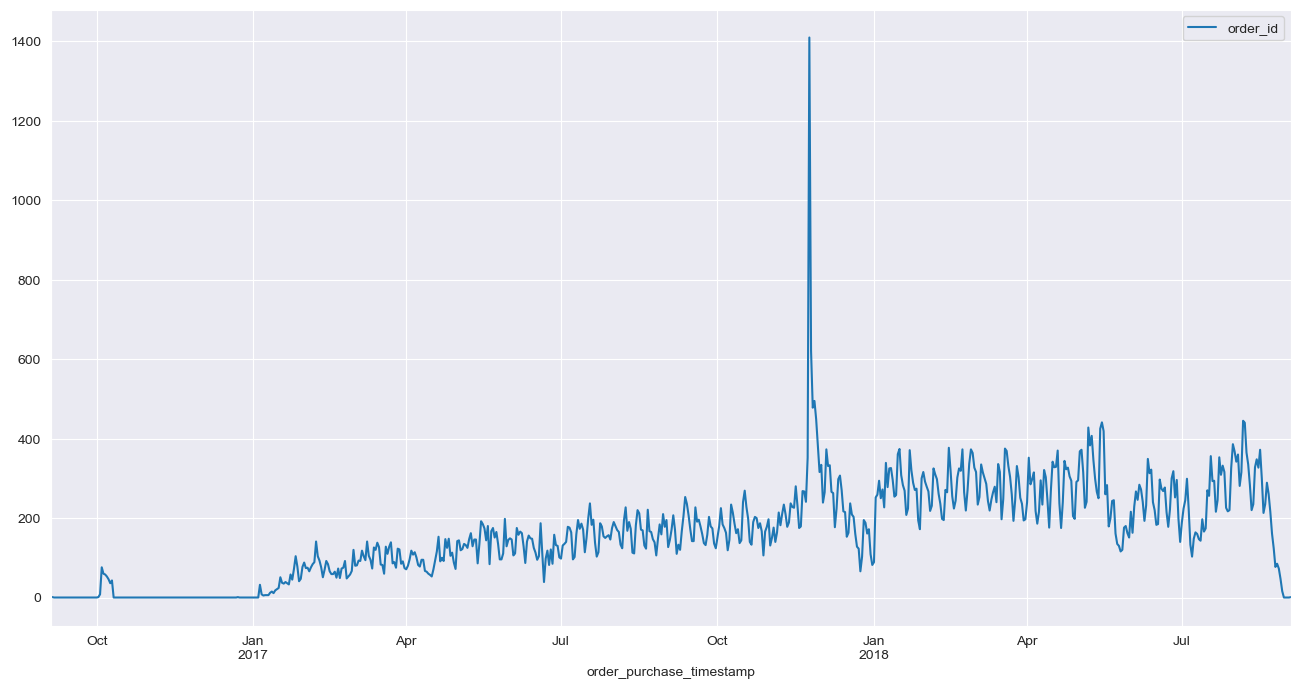

In [293]:
fig = plt.figure(figsize=(16,8))
ax = fig.gca()

counts = df.set_index("order_purchase_timestamp").groupby(pd.Grouper(freq='D')).count()
counts.plot(y = "order_id", use_index=True, ax=ax)

Text(0.5, 1.0, 'Most purchased products')

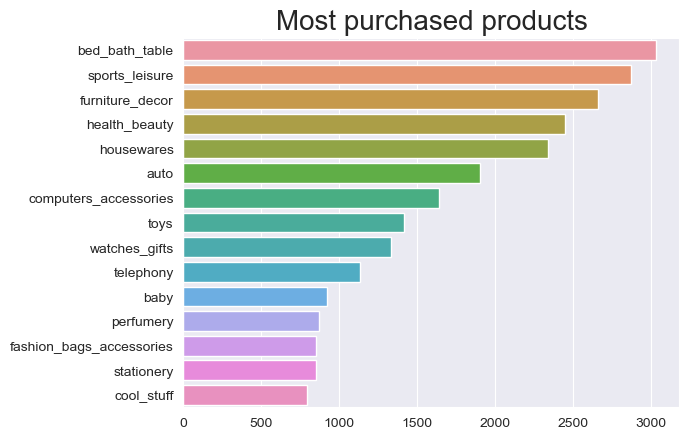

In [294]:
most_purchased = products["product_category_name_english"].value_counts().sort_values(ascending=False)[:15]
sns.barplot(y=most_purchased.index, x=most_purchased.values)
plt.title('Most purchased products',fontsize=20)

Text(0.5, 1.0, 'Type of payments')

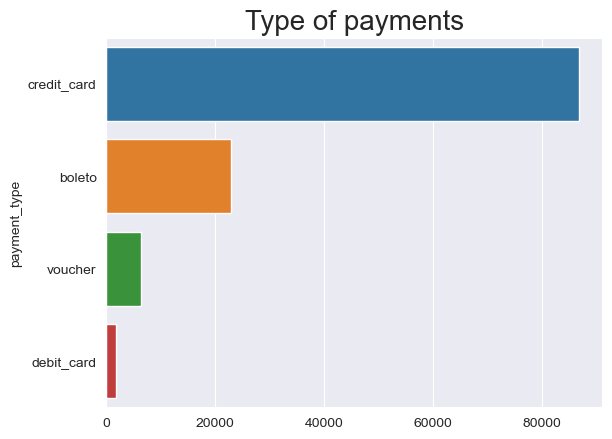

In [295]:
pay = df.groupby('payment_type').size().sort_values(ascending=False)
sns.barplot(y=pay.index,x=pay.values)
plt.title('Type of payments',fontsize=20)

RFM ANALYSIS


RFM stands for Recency, Frequency, and Monetary value, each corresponding to some key customer trait. These RFM metrics are important indicators of a customer's behavior because frequency and monetary value affects a customer's lifetime value, and recency affects retention, a measure of engagement.


![](rfm.png)

Pour calculer la récence, nous devons connaître la date d'achat la plus récente de chaque client et voir pendant combien de jours ils sont inactifs


In [296]:
#Grouping customers by their most recent purchase
recency = df.groupby('customer_unique_id').order_purchase_timestamp.max().reset_index()

#Find the most recent purchase value
most_recent_purchase_date = df['order_purchase_timestamp'].dt.date.max()

#Convert the timestamp into datetime object
recency["order_purchase_timestamp"] = recency["order_purchase_timestamp"].dt.date

#Calculate recency score for each customer
recency['Recency'] = recency['order_purchase_timestamp'].apply(lambda x: (most_recent_purchase_date - x).days)
recency.drop(columns='order_purchase_timestamp')

,customer_unique_id,Recency
0,0000366f3b9a7992bf8c76cfdf3221e2,116
1,0000b849f77a49e4a4ce2b2a4ca5be3f,119
2,0000f46a3911fa3c0805444483337064,542
3,0000f6ccb0745a6a4b88665a16c9f078,326
4,0004aac84e0df4da2b147fca70cf8255,293
...,...,...
95414,fffcf5a5ff07b0908bd4e2dbc735a684,452
95415,fffea47cd6d3cc0a88bd621562a9d061,267
95416,ffff371b4d645b6ecea244b27531430a,573
95417,ffff5962728ec6157033ef9805bacc48,124


FREQUENCY
its the total number orders for each customer

In [297]:
frequency = df.groupby('customer_unique_id').order_purchase_timestamp.count().reset_index()
frequency.rename(columns={'order_purchase_timestamp':'Frequency'},inplace=True)
frequency

,customer_unique_id,Frequency
0,0000366f3b9a7992bf8c76cfdf3221e2,1
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1
2,0000f46a3911fa3c0805444483337064,1
3,0000f6ccb0745a6a4b88665a16c9f078,1
4,0004aac84e0df4da2b147fca70cf8255,1
...,...,...
95414,fffcf5a5ff07b0908bd4e2dbc735a684,2
95415,fffea47cd6d3cc0a88bd621562a9d061,1
95416,ffff371b4d645b6ecea244b27531430a,1
95417,ffff5962728ec6157033ef9805bacc48,1


MONETARY

Monetary score is assigned on the basis of the total revenue generated by the customer in the period under consideration for the analysis. Customers with highest revenue/order amount are assigned a higher score.

In [298]:
monetary = df.groupby('customer_unique_id').payment_value.sum().reset_index()
monetary.rename(columns={'payment_value':'Monetary'},inplace=True)
monetary

,customer_unique_id,Monetary
0,0000366f3b9a7992bf8c76cfdf3221e2,141.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,27.19
2,0000f46a3911fa3c0805444483337064,86.22
3,0000f6ccb0745a6a4b88665a16c9f078,43.62
4,0004aac84e0df4da2b147fca70cf8255,196.89
...,...,...
95414,fffcf5a5ff07b0908bd4e2dbc735a684,4134.84
95415,fffea47cd6d3cc0a88bd621562a9d061,84.58
95416,ffff371b4d645b6ecea244b27531430a,112.46
95417,ffff5962728ec6157033ef9805bacc48,133.69


In [299]:
#Merge the dataframes
rf = recency.merge(frequency, on='customer_unique_id')
rfm = rf.merge(monetary, on='customer_unique_id').drop(columns='order_purchase_timestamp')
rfm.head()

,customer_unique_id,Recency,Frequency,Monetary
0,0000366f3b9a7992bf8c76cfdf3221e2,116,1,141.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,119,1,27.19
2,0000f46a3911fa3c0805444483337064,542,1,86.22
3,0000f6ccb0745a6a4b88665a16c9f078,326,1,43.62
4,0004aac84e0df4da2b147fca70cf8255,293,1,196.89


In [300]:
rfm.describe()

,Recency,Frequency,Monetary
count,95419.000000,95419.000000,95419.000000
mean,243.496484,1.232469,212.831142
std,153.153950,0.823064,641.763082
min,0.000000,1.000000,9.590000
25%,119.000000,1.000000,63.910000
50%,224.000000,1.000000,113.150000
75%,353.000000,1.000000,202.545000
max,729.000000,75.000000,109312.640000


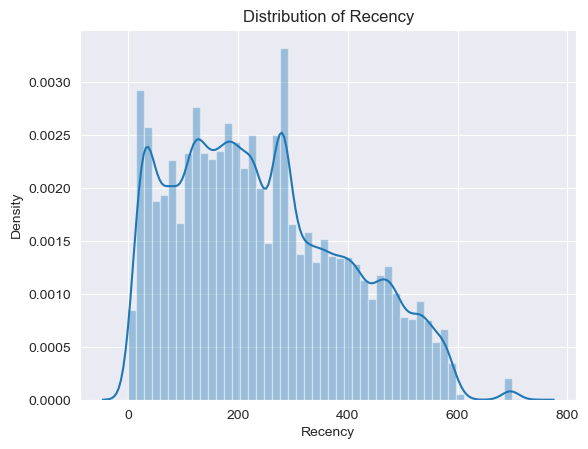

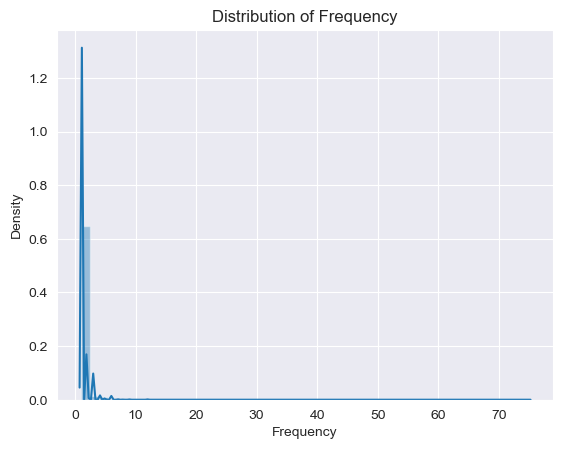

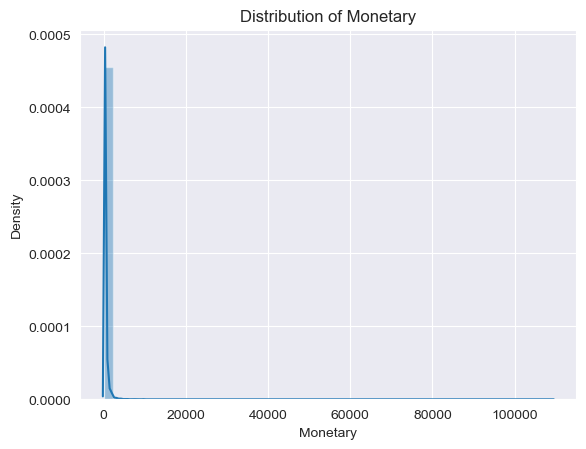

In [301]:
#Visualize the distribution of the RFM features
for col in rfm.columns[1:]:
    distribution_plot(rfm,col)

In [302]:
#Compute each feature quantile and calculate our RFM score for each customer
quantiles = rfm.quantile(q=[0.25,0.50,0.75])
quantiles = quantiles.to_dict()
quantiles

{'Recency': {0.25: 119.0, 0.5: 224.0, 0.75: 353.0},
 'Frequency': {0.25: 1.0, 0.5: 1.0, 0.75: 1.0},
 'Monetary': {0.25: 63.91, 0.5: 113.15, 0.75: 202.54500000000002}}

In [303]:
segmented_rfm = rfm.copy()
segmented_rfm['R_quartile'] = segmented_rfm['Recency'].apply(recency_score,args=('Recency',quantiles))
segmented_rfm['F_quartile'] = segmented_rfm['Frequency'].apply(frequency_monetary_score,args=('Frequency',quantiles))
segmented_rfm['M_quartile'] = segmented_rfm['Monetary'].apply(frequency_monetary_score,args=('Monetary',quantiles))
segmented_rfm['RFM_Segment'] = segmented_rfm.R_quartile.map(str)+segmented_rfm.F_quartile.map(str)+segmented_rfm.M_quartile.map(str)
segmented_rfm['RFM_Score'] = segmented_rfm[['R_quartile','F_quartile','M_quartile']].sum(axis=1)
segmented_rfm.head()

,customer_unique_id,Recency,Frequency,Monetary,R_quartile,F_quartile,M_quartile,RFM_Segment,RFM_Score
0,0000366f3b9a7992bf8c76cfdf3221e2,116,1,141.90,1,4,2,142,7
1,0000b849f77a49e4a4ce2b2a4ca5be3f,119,1,27.19,1,4,4,144,9
2,0000f46a3911fa3c0805444483337064,542,1,86.22,4,4,3,443,11
3,0000f6ccb0745a6a4b88665a16c9f078,326,1,43.62,3,4,4,344,11
4,0004aac84e0df4da2b147fca70cf8255,293,1,196.89,3,4,2,342,9


In [304]:
segmented_rfm['segments'] = segmented_rfm['RFM_Segment'].apply(segment)
segmented_rfm['segments'].value_counts(normalize=True)*100

Regular                                   84.278812
High-spending New Customers                9.579853
Churned Best Customers                     3.086387
Best Customers                             2.541423
Lowest-Spending Active Loyal Customers     0.513525
Name: segments, dtype: float64

## keyword clustering with K-means and tf-idf

In [305]:
df_comments = reviews.loc[:, ['review_score', 'review_comment_message']]
df_comments = df_comments.dropna(subset=['review_comment_message'])
df_comments = df_comments.reset_index(drop=True)
df_comments

,review_score,review_comment_message
0,5,Recebi bem antes do prazo estipulado.
1,5,Parabéns lojas lannister adorei comprar pela I...
2,4,aparelho eficiente. no site a marca do aparelh...
3,4,"Mas um pouco ,travando...pelo valor ta Boa.\r\n"
4,5,"Vendedor confiável, produto ok e entrega antes..."
...,...,...
41748,5,Entregou dentro do prazo. O produto chegou em ...
41749,3,"O produto não foi enviado com NF, não existe v..."
41750,5,"Excelente mochila, entrega super rápida. Super..."
41751,1,Solicitei a compra de uma capa de retrovisor c...


In [306]:
df_comments['review_comment_message']= df_comments['review_comment_message'].apply(lambda x:remove_punctuation(x))
df_comments

,review_score,review_comment_message
0,5,Recebi bem antes do prazo estipulado
1,5,Parabéns lojas lannister adorei comprar pela I...
2,4,aparelho eficiente no site a marca do aparelho...
3,4,Mas um pouco travandopelo valor ta Boa\r\n
4,5,Vendedor confiável produto ok e entrega antes ...
...,...,...
41748,5,Entregou dentro do prazo O produto chegou em c...
41749,3,O produto não foi enviado com NF não existe ve...
41750,5,Excelente mochila entrega super rápida Super r...
41751,1,Solicitei a compra de uma capa de retrovisor c...


In [307]:
df_comments['review_comment_message']= df_comments['review_comment_message'].apply(lambda x: x.lower().strip())
df_comments

,review_score,review_comment_message
0,5,recebi bem antes do prazo estipulado
1,5,parabéns lojas lannister adorei comprar pela i...
2,4,aparelho eficiente no site a marca do aparelho...
3,4,mas um pouco travandopelo valor ta boa
4,5,vendedor confiável produto ok e entrega antes ...
...,...,...
41748,5,entregou dentro do prazo o produto chegou em c...
41749,3,o produto não foi enviado com nf não existe ve...
41750,5,excelente mochila entrega super rápida super r...
41751,1,solicitei a compra de uma capa de retrovisor c...


In [308]:
df_comments['review_comment_message'] = df_comments['review_comment_message'].apply(lambda x: re.sub('W*dw*','',x))
df_comments

,review_score,review_comment_message
0,5,recebi bem antes o prazo estipulao
1,5,parabéns lojas lannister aorei comprar pela in...
2,4,aparelho eficiente no site a marca o aparelho ...
3,4,mas um pouco travanopelo valor ta boa
4,5,veneor confiável prouto ok e entrega antes o p...
...,...,...
41748,5,entregou entro o prazo o prouto chegou em coni...
41749,3,o prouto não foi enviao com nf não existe vena...
41750,5,excelente mochila entrega super rápia super re...
41751,1,solicitei a compra e uma capa e retrovisor cel...


In [309]:
df_comments['review_comment_message']= df_comments['review_comment_message'].apply(lambda x: tokenization(x))
df_comments

,review_score,review_comment_message
0,5,recebi bem antes prazo estipulao
1,5,parabéns lojas lannister aorei comprar interne...
2,4,aparelho eficiente site marca aparelho impress...
3,4,pouco travanopelo valor ta boa
4,5,veneor confiável prouto ok entrega antes prazo
...,...,...
41748,5,entregou entro prazo prouto chegou conições pe...
41749,3,prouto enviao nf existe vena nf certeza fico a...
41750,5,excelente mochila entrega super rápia super re...
41751,1,solicitei compra capa retrovisor celtaprismame...


In [310]:
tfidf = TfidfVectorizer(min_df=2, max_df=0.95)
# fit_transform applies TF-IDF to clean texts - we save the array of vectors in X
X = tfidf.fit_transform(df_comments['review_comment_message'])

In [311]:
feat_names = tfidf.get_feature_names()[:10]
feat_names

['00',
 '001689',
 '01',
 '01032018',
 '01062018',
 '01082018',
 '011',
 '0111',
 '01122017',
 '0165096389']

In [312]:
from sklearn.decomposition import PCA
# initialize PCA with 2 components
pca = PCA(n_components=2)
pca_vecs = pca.fit_transform(X.toarray())
x0 = pca_vecs[:, 0]
x1 = pca_vecs[:, 1]

<AxesSubplot:>

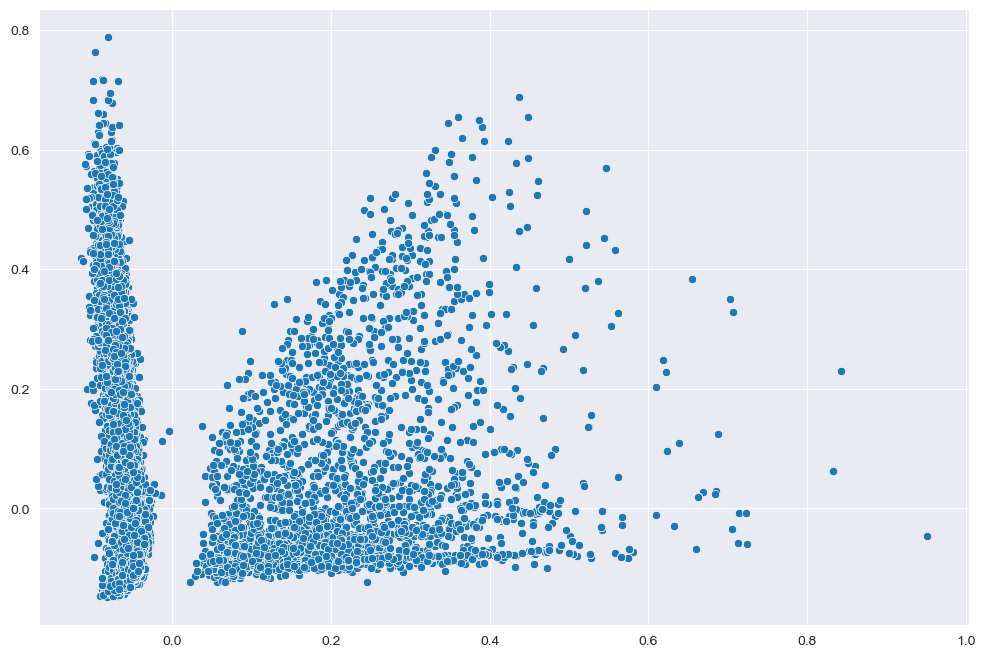

In [313]:
plt.figure(figsize=(12,8))
sns.scatterplot(x = x0, y = x1 ,legend="full")

In [314]:
X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf = train_test_split(pca_vecs, df_comments['review_score'], test_size = 0.25, random_state = 20)

In [315]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
rf = RandomForestClassifier()
rf.fit(X_train_tfidf,y_train_tfidf)
scores = cross_val_score(rf,X_train_tfidf,y_train_tfidf.values.ravel(),cv=5)
print(scores)
scores.mean()

[0.48970142 0.51301293 0.50439087 0.5037522  0.50335356]


0.502842195547219

In [316]:
tfidf.get_feature_names()

['00',
 '001689',
 '01',
 '01032018',
 '01062018',
 '01082018',
 '011',
 '0111',
 '01122017',
 '0165096389',
 '0166821151neste',
 '01um',
 '02',
 '02012018',
 '020218',
 '02032018',
 '0205',
 '02082018',
 '03',
 '0302',
 '0303',
 '03032018',
 '0304',
 '04',
 '0401',
 '0404',
 '0405',
 '0407',
 '0408',
 '041217',
 '05',
 '0501',
 '0502',
 '0503',
 '0504',
 '06',
 '0601',
 '060118',
 '06032018',
 '06042018',
 '0606',
 '06062018',
 '0608',
 '06082018',
 '0612',
 '062018',
 '07',
 '0702',
 '0705',
 '0712',
 '071217',
 '08',
 '0800',
 '0801',
 '08012018',
 '0802',
 '08022018',
 '0803',
 '0805',
 '08082018',
 '0812',
 '08122017',
 '09',
 '0902',
 '0904',
 '09072018',
 '0908',
 '10',
 '100',
 '1000',
 '10000',
 '1001',
 '1003',
 '1004',
 '10042018',
 '1005',
 '1008',
 '10082018',
 '100w',
 '101',
 '1010',
 '102',
 '10x',
 '11',
 '110',
 '1103',
 '1104',
 '110418',
 '1107',
 '110v',
 '1112',
 '11122017',
 '12',
 '120',
 '1200',
 '12000',
 '1204',
 '1206',
 '1207',
 '1210',
 '1212',
 '122',
 '1